# Data description & Problem statement: 
This dataset describes a monthly count of the number of observed sunspots for just over 230 years (1749-1983). The units are a count and there are 2,820 observations. The source of the dataset is credited to Andrews & Herzberg (1985).

# Workflow:
- Load the Time Series (TS) by Pandas Library

 # 1)  Exploration of Time Series:
- TS Line, Histogram & Probability plots
- TS Line & Box plots by intervals
- TS Lag plots
- Check the stationarity of TS, by:
     - Plotting rolling mean & standard deviation
     - Perform Dickey-Fuller test
     - Decomposition of TS into Trend, Seasonal part and residuals

 #  2) Seasonal ARIMA model:
- Build and evaluate the Seasonal ARIMA model: 
     - Grid-Search for the best ARIMA parameters
     - Fit the best ARIMA model
     - Evaluate model by in-sample prediction: Calculate RMSE
- Forecast the future trend: Out-of-sample prediction

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rn
%matplotlib inline

import os
os.environ['PYTHONHASHSEED'] = '0'

# for the reproducable results:
np.random.seed(42)
rn.seed(42)

import warnings
warnings.filterwarnings("ignore")

In [12]:
# Load data using Series.from_csv
from pandas import Series, DataFrame
#TS = Series.from_csv('C:/Users/rhash/Documents/Datasets/Time Series analysis/daily-minimum-temperatures.csv', header=0)

# Load data using pandas.read_csv
# in case, specify your own date parsing function and use the date_parser argument
from pandas import read_csv
TS = read_csv('C:/Users/rhash/Documents/Datasets/Time Series analysis/zuerich-monthly-sunspot-numbers-.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

print(TS.head())

Month
1749-01-01    58.0
1749-02-01    62.6
1749-03-01    70.0
1749-04-01    55.7
1749-05-01    85.0
Name: Zuerich monthly sunspot numbers 1749-1983, dtype: float64


In [3]:
#TS=pd.to_numeric(TS, errors='coerce')
TS.dropna(inplace=True)

In [4]:
TS.index

DatetimeIndex(['1749-01-01', '1749-02-01', '1749-03-01', '1749-04-01',
               '1749-05-01', '1749-06-01', '1749-07-01', '1749-08-01',
               '1749-09-01', '1749-10-01',
               ...
               '1983-03-01', '1983-04-01', '1983-05-01', '1983-06-01',
               '1983-07-01', '1983-08-01', '1983-09-01', '1983-10-01',
               '1983-11-01', '1983-12-01'],
              dtype='datetime64[ns]', name='Month', length=2820, freq=None)

In [5]:
TS.describe()

count    2820.000000
mean       51.265957
std        43.448971
min         0.000000
25%        15.700000
50%        42.000000
75%        74.925000
max       253.800000
Name: Zuerich monthly sunspot numbers 1749-1983, dtype: float64

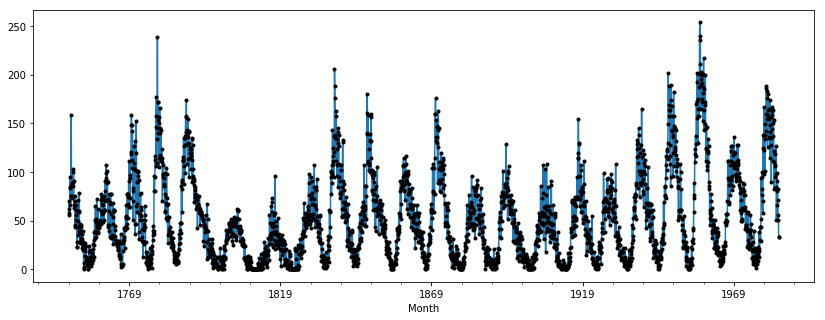

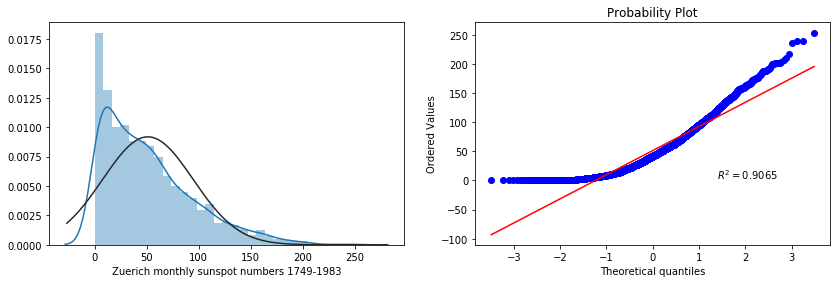

In [6]:
# Time Series Line Plot: _________________________________________
plt.figure(figsize=(14, 5))
TS.plot()
TS.plot(style="k.")
plt.show()

#Time Series Histogram and Density Plot:
fig = plt.figure(figsize=(14, 9))
ax1 = fig.add_subplot(221)
ax1=sns.distplot(TS, fit=stats.norm)
    
ax2 = fig.add_subplot(222)
res=stats.probplot(TS, plot=ax2, rvalue=True)

In [ ]:
# Time Series Line, Box and Whisker Plots by Intervals: _________________________________________________
from pandas import Series
from pandas import DataFrame
from pandas import TimeGrouper

groups = TS.groupby(TimeGrouper('Y'))
years = DataFrame()

for name, group in groups:
    years[ name.year]=group.values[0:12]
    
years.plot(subplots=True, legend=False, figsize=(8,10))
plt.show()

years.boxplot(figsize=(8,8))
plt.show()

plt.matshow(years.T, interpolation=None, aspect='auto')
plt.colorbar()
plt.show()

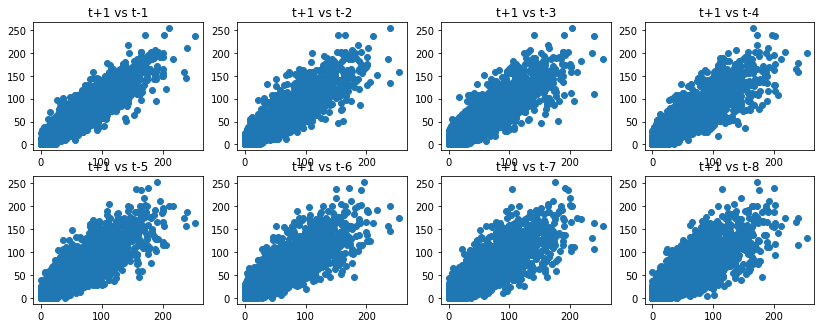

In [13]:
# Time Series Lag Scatter Plots: ____________________________________________________
from pandas import concat
from pandas.plotting import scatter_matrix

plt.figure(figsize=(14, 8))

values = DataFrame(TS.values)
lags = 8
columns = [values]
for i in range(1,(lags + 1)):
    columns.append(values.shift(i))
dataframe = concat(columns, axis=1)
columns = ['t+1']

for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
dataframe.columns = columns
plt.figure(1)

for i in range(1,(lags + 1)):
    ax = plt.subplot(340 + i)
    ax.set_title('t+1 vs t-' + str(i))
    plt.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)

plt.show()

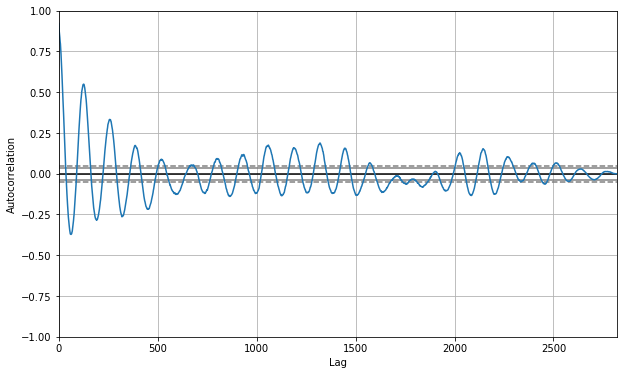

In [14]:
#Time Series Autocorrelation Plot: ________________________________________________________
from pandas.tools.plotting import autocorrelation_plot

plt.figure(figsize=(10, 6))
autocorrelation_plot(TS)
plt.show()

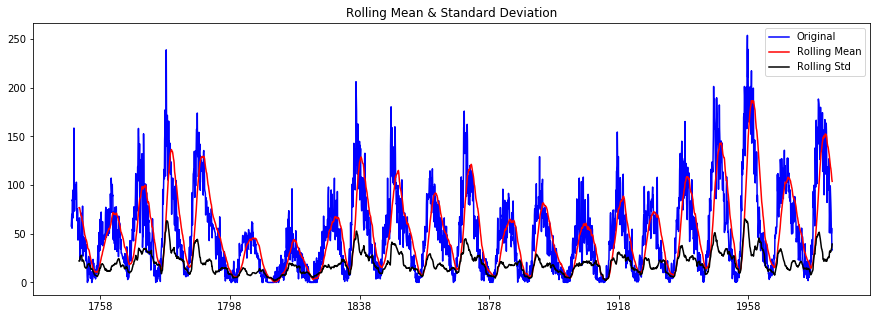

Results of Dickey-Fuller Test:
Test Statistic                -9.567668e+00
p-value                        2.333452e-16
#Lags Used                     2.700000e+01
Number of Observations Used    2.792000e+03
Critical Value (1%)           -3.432694e+00
Critical Value (5%)           -2.862576e+00
Critical Value (10%)          -2.567321e+00
dtype: float64


In [15]:
# To check the stationarity of Time Series: _________________________________________________
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, win=12):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=win).mean()
    rolstd = timeseries.rolling(window=win).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)
    
    
test_stationarity(TS, win=30)

In [16]:
import statsmodels.api as sm

In [23]:
# load passenger data set and save to DataFrame
df = pd.read_csv('C:/Users/rhash/Documents/Datasets/Time Series analysis/zuerich-monthly-sunspot-numbers-.csv', header=0, index_col=0, parse_dates=True, sep=',')
 
# create Series object
y = df['Zuerich monthly sunspot numbers 1749-1983']

y_train = y[:'1930']
y_test = y['1930':]
# split into training and test sets
#y=TS.values
#y_train = TS[:'1958'].values
#y_test = TS['1959':].values

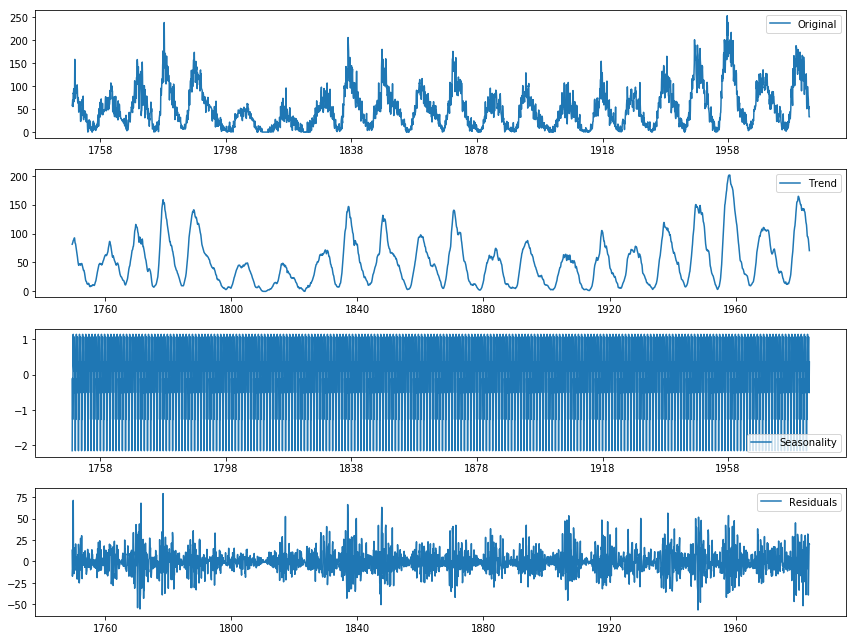

In [24]:
# Decomposition of TS into Trend, Seasonal part and residuals
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 9))
plt.subplot(411)
plt.plot(y, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [14]:
import itertools
# define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)
 
# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
 
# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [15]:
# Grid-Search for the best ARIMA parameters:
import sys
import warnings
warnings.filterwarnings("ignore")
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

from sklearn.metrics import mean_squared_error
L=[]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(y_train,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=True)
            res = tmp_mdl.fit(n_jobs=-1)
            pred = res.get_prediction(start=pd.to_datetime('1949-01-01'), 
                          end=pd.to_datetime('1958-12-01'),
                          dynamic=False)
            
            
            RMSE= np.sqrt(mean_squared_error(y_train.values, pred.predicted_mean.values))
            print('RMSE= ', RMSE, ',  ', '(p,d,q)= ', param, ',  ','(P,D,Q)= ', param_seasonal, sep='')
            L.append([RMSE,param, param_seasonal] )
            
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
                
        except:
            continue

print("\n Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

RMSE= 263.4573811201096,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (0, 0, 0, 12)
RMSE= 50.72162589402407,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (0, 1, 0, 12)
RMSE= 47.08815553891897,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (0, 1, 1, 12)
RMSE= 47.70805939175198,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (0, 2, 0, 12)
RMSE= 46.28874246214289,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (0, 2, 1, 12)
RMSE= 44.74170964857888,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (1, 1, 0, 12)
RMSE= 43.92137176625296,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (1, 1, 1, 12)
RMSE= 43.92170220508947,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (1, 1, 2, 12)
RMSE= 46.99594729064216,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (1, 2, 0, 12)
RMSE= 46.28744015129867,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (1, 2, 1, 12)
RMSE= 44.386855060325466,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (2, 1, 0, 12)
RMSE= 43.92046141120182,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (2, 1, 1, 12)
RMSE= 43.79086737216075,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (2, 1, 2, 12)
RMSE= 46.87039662185666,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (2, 2, 0, 12)
RMSE= 46.2812108245

RMSE= 16.965744855806975,  (p,d,q)= (0, 2, 1),  (P,D,Q)= (0, 1, 2, 12)
RMSE= 21.94548667763909,  (p,d,q)= (0, 2, 1),  (P,D,Q)= (0, 2, 0, 12)
RMSE= 20.074989076934507,  (p,d,q)= (0, 2, 1),  (P,D,Q)= (0, 2, 1, 12)
RMSE= 16.98012082892868,  (p,d,q)= (0, 2, 1),  (P,D,Q)= (1, 1, 0, 12)
RMSE= 16.976778820835605,  (p,d,q)= (0, 2, 1),  (P,D,Q)= (1, 1, 1, 12)
RMSE= 16.97817154456744,  (p,d,q)= (0, 2, 1),  (P,D,Q)= (1, 1, 2, 12)
RMSE= 20.608471239753964,  (p,d,q)= (0, 2, 1),  (P,D,Q)= (1, 2, 0, 12)
RMSE= 19.97212042849281,  (p,d,q)= (0, 2, 1),  (P,D,Q)= (1, 2, 1, 12)
RMSE= 16.970674324451757,  (p,d,q)= (0, 2, 1),  (P,D,Q)= (2, 1, 0, 12)
RMSE= 16.84789997485388,  (p,d,q)= (0, 2, 1),  (P,D,Q)= (2, 1, 1, 12)
RMSE= 16.949594876858804,  (p,d,q)= (0, 2, 1),  (P,D,Q)= (2, 1, 2, 12)
RMSE= 20.22207449994094,  (p,d,q)= (0, 2, 1),  (P,D,Q)= (2, 2, 0, 12)
RMSE= 19.970458809288093,  (p,d,q)= (0, 2, 1),  (P,D,Q)= (2, 2, 1, 12)
RMSE= 29.375010053903843,  (p,d,q)= (0, 2, 2),  (P,D,Q)= (0, 0, 0, 12)
RMSE= 21.664

RMSE= 18.17890595977183,  (p,d,q)= (1, 1, 2),  (P,D,Q)= (0, 2, 1, 12)
RMSE= 15.397824600667093,  (p,d,q)= (1, 1, 2),  (P,D,Q)= (1, 1, 0, 12)
RMSE= 15.37043906034138,  (p,d,q)= (1, 1, 2),  (P,D,Q)= (1, 1, 1, 12)
RMSE= 15.158758520916878,  (p,d,q)= (1, 1, 2),  (P,D,Q)= (1, 1, 2, 12)
RMSE= 18.589890759862236,  (p,d,q)= (1, 1, 2),  (P,D,Q)= (1, 2, 0, 12)
RMSE= 18.057220167406456,  (p,d,q)= (1, 1, 2),  (P,D,Q)= (1, 2, 1, 12)
RMSE= 15.33338925670786,  (p,d,q)= (1, 1, 2),  (P,D,Q)= (2, 1, 0, 12)
RMSE= 15.164486321152646,  (p,d,q)= (1, 1, 2),  (P,D,Q)= (2, 1, 1, 12)
RMSE= 15.225240424004916,  (p,d,q)= (1, 1, 2),  (P,D,Q)= (2, 1, 2, 12)
RMSE= 18.291230213515234,  (p,d,q)= (1, 1, 2),  (P,D,Q)= (2, 2, 0, 12)
RMSE= 18.056180506745488,  (p,d,q)= (1, 1, 2),  (P,D,Q)= (2, 2, 1, 12)
RMSE= 35.13240307480381,  (p,d,q)= (1, 2, 0),  (P,D,Q)= (0, 0, 0, 12)
RMSE= 25.17159287440178,  (p,d,q)= (1, 2, 0),  (P,D,Q)= (0, 0, 1, 12)
RMSE= 18.223330043419953,  (p,d,q)= (1, 2, 0),  (P,D,Q)= (0, 1, 0, 12)
RMSE= 18.18

RMSE= 18.625417550507706,  (p,d,q)= (2, 1, 0),  (P,D,Q)= (1, 2, 0, 12)
RMSE= 18.068144440832786,  (p,d,q)= (2, 1, 0),  (P,D,Q)= (1, 2, 1, 12)
RMSE= 15.343324470609561,  (p,d,q)= (2, 1, 0),  (P,D,Q)= (2, 1, 0, 12)
RMSE= 15.169190379804759,  (p,d,q)= (2, 1, 0),  (P,D,Q)= (2, 1, 1, 12)
RMSE= 15.231243815176173,  (p,d,q)= (2, 1, 0),  (P,D,Q)= (2, 1, 2, 12)
RMSE= 18.303202218937717,  (p,d,q)= (2, 1, 0),  (P,D,Q)= (2, 2, 0, 12)
RMSE= 18.06580133819357,  (p,d,q)= (2, 1, 0),  (P,D,Q)= (2, 2, 1, 12)
RMSE= 26.96640601703582,  (p,d,q)= (2, 1, 1),  (P,D,Q)= (0, 0, 0, 12)
RMSE= 19.983014830219712,  (p,d,q)= (2, 1, 1),  (P,D,Q)= (0, 0, 1, 12)
RMSE= 17.748483201176708,  (p,d,q)= (2, 1, 1),  (P,D,Q)= (0, 0, 2, 12)
RMSE= 24.67090449349023,  (p,d,q)= (2, 1, 2),  (P,D,Q)= (0, 0, 0, 12)
RMSE= 19.1675310374384,  (p,d,q)= (2, 1, 2),  (P,D,Q)= (0, 0, 1, 12)
RMSE= 17.219041484870242,  (p,d,q)= (2, 1, 2),  (P,D,Q)= (0, 0, 2, 12)
RMSE= 15.279262638517176,  (p,d,q)= (2, 1, 2),  (P,D,Q)= (0, 1, 0, 12)
RMSE= 15.27

In [38]:
L.sort()
L[0:5]

[[15.057789642182563, (2, 1, 2), (1, 1, 2, 12)],
 [15.076853240692683, (2, 1, 2), (2, 1, 1, 12)],
 [15.12649597811113, (2, 1, 2), (2, 1, 2, 12)],
 [15.158758520916878, (1, 1, 2), (1, 1, 2, 12)],
 [15.162212035812942, (1, 1, 1), (1, 1, 2, 12)]]

In [109]:
# define SARIMAX model and fit it to the data
mdl = sm.tsa.statespace.SARIMAX(y_train,
                                order=(2, 1, 2),
                                seasonal_order=(2, 1, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
res = mdl.fit()

In [110]:
# print statistics
#print(res.aic)
#print(res.summary())

In [111]:
#res.plot_diagnostics(figsize=(16, 10))
#plt.tight_layout()
#plt.show()

Validation RMSE :  40.641938425300516


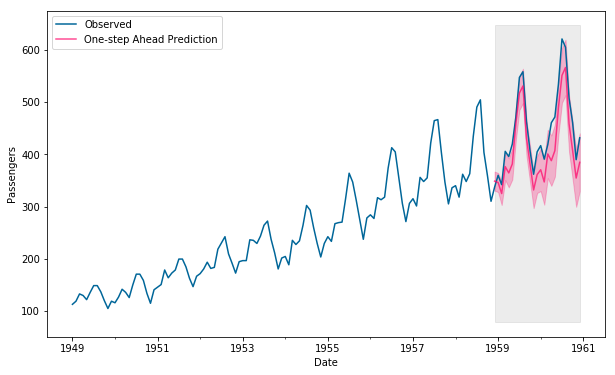

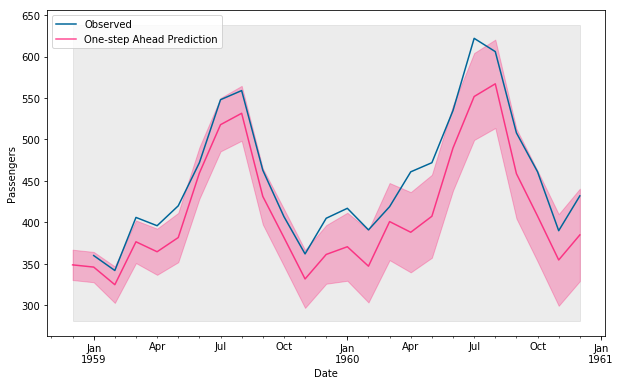

In [112]:
# fit model to data
# In-sample-prediction and confidence bounds
pred = res.get_prediction(start=pd.to_datetime('1958-12-01'), 
                          end=pd.to_datetime('1960-12-01'),
                          dynamic=False)
pred_ci = pred.conf_int()

print('Validation RMSE : ', np.sqrt(mean_squared_error(y['1958-12-01': ].values, pred.predicted_mean.values)))

# plot in-sample-prediction
plt.figure(figsize=(10, 6))
ax = y['1949':].plot(label='Observed',color='#006699');
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, color='#ff0066');
 
# draw confidence bound (gray)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
 
# style the plot
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1958-12-01'), y.index[-1], alpha=.15, zorder=-1, color='grey');
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend(loc='upper left')
plt.show()

# plot in-sample-prediction
plt.figure(figsize=(10, 6))
ax = y['1959':].plot(label='Observed',color='#006699');
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, color='#ff0066');
 
# draw confidence bound (gray)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
 
# style the plot
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1958-12-01'), y.index[-1], alpha=.15, zorder=-1, color='grey');
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend(loc='upper left')
plt.show()

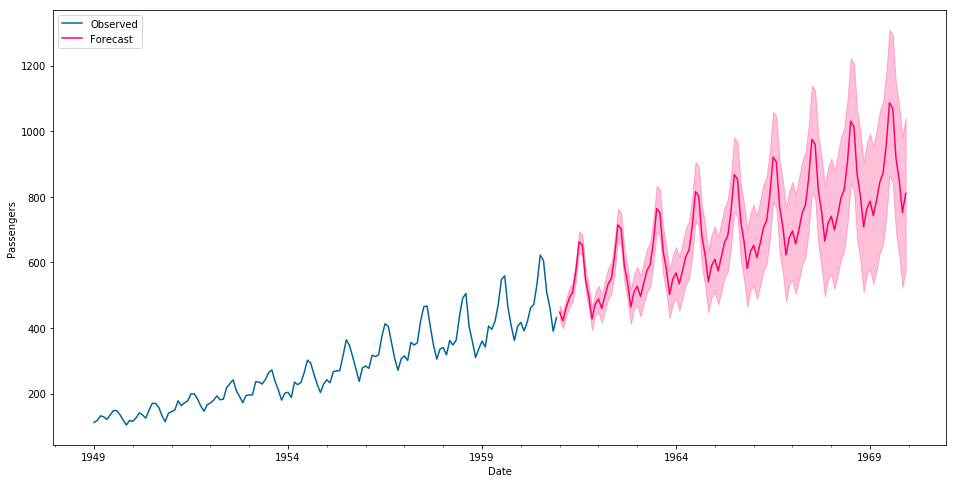

In [113]:
# Forecast (out-of-sample prediction)
mdl = sm.tsa.statespace.SARIMAX(y,
                                order=(2, 1, 2),
                                seasonal_order=(2, 1, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
res = mdl.fit(dynamics=False)

# get forecast 120 steps ahead in future
pred_uc = res.get_forecast(steps=108)
 
# get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
 
# plot time series and long-term forecast
ax = y.plot(label='Observed', figsize=(16, 8), color='#006699');
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', color='#ff0066');
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
ax.set_xlabel('Date');
ax.set_ylabel('Passengers');
plt.legend(loc='upper left')
plt.show()